In [92]:
%matplotlib notebook
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv, lstsq

from poly_basis import *
from spherepts import *
from rbf import *

from math import *

In [93]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [94]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def L_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        r2 = dist(x,y)**2
        ret -= sigma*np.exp(-sigma*r2) * (4+r2*(-2+(-4+r2)*sigma))
    return ret
    
def sum_gauss(x, sigmas, ys):
    ret = 0
    for sigma, y in zip(sigmas,ys):
        ret += np.exp(-sigma*dist(x,y)**2)
    return ret

def get_exact(harm_index):
    if harm_index is 'gaussians':
        sigmas = [2, .5, .3, .1, 5, 2, 1.5]
        ys = np.array([ [0,0,1],
                        [1,-1,1],
                        [2,0,1],
                        [-5,7,0],
                        [2,-13,1],
                        [2,12,-15],
                        [1,0,-1]], dtype=np.float)
        # project the centers onto the sphere
        for i, y in enumerate(ys):
            ys[i] = 1.0/norm(y)* y
        foo = lambda x: sum_gauss(x, sigmas, ys)
        exact = lambda x: L_gauss(x, sigmas, ys)
    else:
        # f is a spherical harmoic of degree below
        harm_index = harm_index

        sol_deg = sphere_harm_degs[harm_index]
        foo = lambda x: sphere_harm[harm_index](*x)
        exact = lambda x: -sol_deg*(sol_deg+1)*foo(x)
        print('Harmonic degree: %d' % sphere_harm_degs[harm_index])

    return foo, exact

In [109]:
n = 20000
k = 200
center = 100
rbf_obj = rbf_dict['multiquadric']
eps = 2
foo, exact = get_exact('gaussians')
# foo, exact = get_exact(10)

nodes = gen_spiral_nodes(n)
normals = nodes
tree = cKDTree(np.array(nodes))
stencil = tree.query(nodes[center], k)[1]
nn = nodes[stencil]

<IPython.core.display.Javascript object>


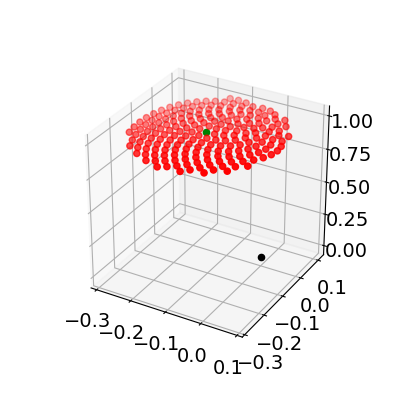

In [110]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nn[1:,0], nn[1:,1], nn[1:,2], '.', color='r')
ax.scatter(nn[0,0], nn[0,1], nn[0,2], '.', color='g')
ax.scatter(0, 0, 0, '.', color='k')

plt.show()

In [74]:
phi  = rbf_obj['rbf']
phi1 = rbf_obj['zeta']
phi2 = rbf_obj['chi']
phi3 = rbf_obj['beta']
phi4 = rbf_obj['gamma']
d2phi = rbf_obj['d2rbf']
def Gx(r, d, eps):
    return d*phi1(r,eps)
def Hx(r, d,eps):
    return phi1(r,eps) + d**2 * phi2(r,eps)
def GHx(r, d,eps):
    return 3*d*phi2(r,eps) + d**3 * phi3(r,eps)
def HHx(r, d,eps):
    return 3*phi2(r,eps) + 6 * d**2 * phi3(r,eps) + d**4 * phi4(r,eps)
def Lphi(r, eps):
    return 2*phi1(r,eps) + d2phi(r,eps)
#     return 3*phi1(r,eps) + r**2 * phi2(r,eps)
def LG(r, d,eps):
    return 5*d*phi2(r,eps) + r**2 * d * phi3(r,eps)
def LH(r,d,eps):
    return 5*phi2(r,eps) + (r**2 + 7*d**2)*phi3(r,eps) + (d*r)**2 * phi4(r,eps)

In [111]:
nn = nodes[stencil]
r = dist_outer(nn,nn)
d = (nn - nn[0]) @ nn[0]

eps = optimize_eps(phi, r, P=None, target_cond=10**12)
print('eps set to %g' % eps)

B = np.zeros(k+2)

B[:k] = Lphi(r[0], eps)
B[-2] = LG(0, 0, eps)
B[-1] = LH(0, 0, eps)

A = np.zeros((k+2,k+2))
A[:k, :k] = phi(r, eps)
A[:k, -2] = -Gx(r[0], d, eps)
A[:k, -1] = Hx(r[0], d, eps)

A[-2, -2] = -Hx(0, 0, eps)
A[-2, -1] = -GHx(0, 0, eps)
A[-1, -1] = HHx(0, 0, eps)

A[-2, :k] = A[:k, -2]
A[-1, :-1] = A[:-1, -1]
# A[-1, -2] = A[-2, -1]


print('cond(A) = %g' % np.log10(cond(A)))
print('cond(phi(r))= %g' % np.log10(cond(A[:k,:k])))

# C = (B @ la.inv(A))[:,:k]
C = la.solve(A, B)[:k]

fs = np.array([foo(node) for node in nn])
d = exact(nodes[center])

u = C @ fs

print('approx = %g' % u)
print('exact  = %g' % d)

rel_error_L2  = np.abs(u-d)/np.abs(d)
print('\nerror: %g' % rel_error_L2)

eps set to 6.6894
cond(A) = 13.2691
cond(phi(r))= 12
approx = -7.55063
exact  = -7.54876

error: 0.000247008


# Scaling

In [167]:
nn = nodes[stencil]
fs = np.array([foo(node) for node in nn])
df = exact(nodes[center])
normal = nodes[center]

nn -= nn[0]
scale = np.max(np.abs(nn))

print('scale = %g' % scale)

nn /= scale

r = dist_outer(nn,nn)
d = nn @ normal

eps = optimize_eps(phi, r, P=None, target_cond=10**12)
print('eps set to %g' % eps)
print('relative eps = %g' % (eps/scale))

B = np.zeros(k+2)

B[:k] = Lphi(r[0], eps)/scale**2
B[-2] = LG(0, 0, eps)/scale**3
B[-1] = LH(0, 0, eps)/scale**4

A = np.zeros((k+2,k+2))
A[:k, :k] = phi(r, eps)
A[:k, -2] = -Gx(r[0], d, eps)/scale
A[:k, -1] = Hx(r[0], d, eps)/scale**2

A[-2, -2] = -Hx(0, 0, eps)/scale**2
A[-2, -1] = -GHx(0, 0, eps)/scale**3
A[-1, -1] = HHx(0, 0, eps)/scale**4

A[-2, :k] = A[:k, -2]
A[-1, :-1] = A[:-1, -1]


print('cond(A) = %g' % np.log10(cond(A)))
print('cond(phi(r))= %g' % np.log10(cond(A[:k,:k])))

# C = (B @ la.inv(A))[:,:k]
C = la.solve(A, B)[:k]

u = C @ fs

print('approx = %g' % u)
print('exact  = %g' % df)

rel_error_L2  = np.abs(u-df)/np.abs(df)
print('\nerror: %g' % rel_error_L2)

scale = 0.196129
eps set to 1.31198
relative eps = 6.6894
cond(A) = 13.2691
cond(phi(r))= 12
approx = -7.55063
exact  = -7.54876

error: 0.000247007


# Polynomial terms

In [265]:
from math import factorial as fac
def grad_poly(nodes, projectors, deg):
    n = len(nodes)
    x = nodes[:,0]
    y = nodes[:,1]
    z = nodes[:,2]
    cols = fac(deg+3)//(fac(deg)*fac(3))
    P = np.zeros((n, cols))
    rhs_dx = np.zeros((cols, n))
    rhs_dy = np.zeros((cols, n))
    rhs_dz = np.zeros((cols, n))
    rhs_x = np.zeros((cols, n))
    rhs_y = np.zeros((cols, n))
    rhs_z = np.zeros((cols, n))
    i = 0
    for d in range(deg+1):
        #x^a y^b z^c with a+b+c = d
        for a in range(d,-1, -1):
            for b in range(d-a, -1, -1):
                c = d-a-b
                P[:,i] = x**a * y**b * z**c
                if a == 0:
                    rhs_dx[i] = 0
                else:
                    rhs_dx[i] = a * x**(a-1) * y**b * z**c
                if b == 0:
                    rhs_dy[i] = 0
                else:
                    rhs_dy[i] = b * x**a * y**(b-1) * z**c
                if c == 0:
                    rhs_dz[i] = 0
                else:
                    rhs_dz[i] = c * x**a * y**b * z**(c-1)
                i += 1
    for i, p in enumerate(projectors):
        rhs_x[:,i] = p[0,0]*rhs_dx[:,i] + p[1,0]*rhs_dy[:,i] + p[2,0]*rhs_dz[:,i]
        rhs_y[:,i] = p[0,1]*rhs_dx[:,i] + p[1,1]*rhs_dy[:,i] + p[2,1]*rhs_dz[:,i]
        rhs_z[:,i] = p[0,2]*rhs_dx[:,i] + p[1,2]*rhs_dy[:,i] + p[2,2]*rhs_dz[:,i]
    return P, rhs_x, rhs_y, rhs_z

def schur_solve(A, P, f, g):
    lam = la.solve(P.T @ la.solve(A, P), P.T @ la.solve(A,f) - g)
    w = la.solve(A, f- P@lam)
    return w, lam

In [351]:
poly_deg = 5

nn = nodes[stencil]
fs = np.array([foo(node) for node in nn])
df = exact(nodes[center])
normal = nodes[center]

nn -= nn[0]
scale = np.max(np.abs(nn))

print('scale = %g' % scale)

nn /= scale

r = dist_outer(nn,nn)
d = nn @ normal

P, *trash = grad_poly(nn, [], poly_deg)
terms = P.shape[1]

eps = optimize_eps(phi, r, P=None, target_cond=10**12)
print('eps set to %g' % eps)
print('relative eps = %g' % (eps/scale))

B = np.zeros(k+2+terms)

B[:k] = Lphi(r[0], eps)/scale**2
B[k] = LG(0, 0, eps)/scale**3
B[k+1] = LH(0, 0, eps)/scale**4

A = np.zeros((k+2+terms,k+2+terms))
A[:k, k+2:] = P
A[k+2:, :k] = P.T

if poly_deg >= 1:
    # Lp
    A[k, k+3:k+6] = normal/scale
    A[k+3:k+6, k] = normal/scale
if poly_deg >= 2:
    # Hp
    nHn = 2*np.outer(normal, normal)/scale**2
    A[k+1, k+6:k+9] = nHn[0]
    A[k+1, k+9:k+11] = nHn[1, 1:]
    A[k+1, k+11] = nHn[2,2]
    A[k+6:k+12, k+1] = A[k+1, k+6:k+12]
    
    B[k+6] = 2/scale**2
    B[k+9] = 2/scale**2
    B[k+11] = 2/scale**2

A[:k,  :k] = phi(r, eps)
A[:k,   k] = -Gx(r[0], d, eps)/scale
A[:k, k+1] = Hx(r[0], d, eps)/scale**2

A[ k, k] = -Hx(0, 0, eps)/scale**2
A[k, k+1] = -GHx(0, 0, eps)/scale**3
A[k+1, k+1] = HHx(0, 0, eps)/scale**4

A[k, :k] = A[:k, k]
A[k+1, :k+1] = A[:k+1, k+1]



print('cond(phi(r))= %g' % np.log10(cond(A[:k,:k])))
print('cond(OGr)= %g' % np.log10(cond(A[:k+2,:k+2])))
print('cond(A) = %g' % np.log10(cond(A)))

# C = la.solve(A, B)
C = schur_solve(A[:k+2,:k+2], A[:k+2, k+2:], B[:k+2], B[k+2:])
# C1 = np.block([C1[0], C1[1]])

# print('shur diff', np.max(np.abs(C-C1)))
# C = C1

C = C[0][:k]
u = C @ fs

print('approx = %g' % u)
print('exact  = %g' % df)

rel_error_L2  = np.abs(u-df)/np.abs(df)
print('\nerror: %g' % rel_error_L2)

scale = 0.196129
eps set to 1.31198
relative eps = 6.6894
cond(phi(r))= 12
cond(OGr)= 13.2691
cond(A) = 23.6566
approx = -7.54876
exact  = -7.54876

error: 1.93478e-08
